<a href="https://colab.research.google.com/github/devpandey2010/NLP-NATURAL-LANGUAGE-PROCESSOR-/blob/main/16_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Full Code with Forward + BPTT

📉 Loss Before Update: 0.4297
📉 Loss After  Update: 0.1972


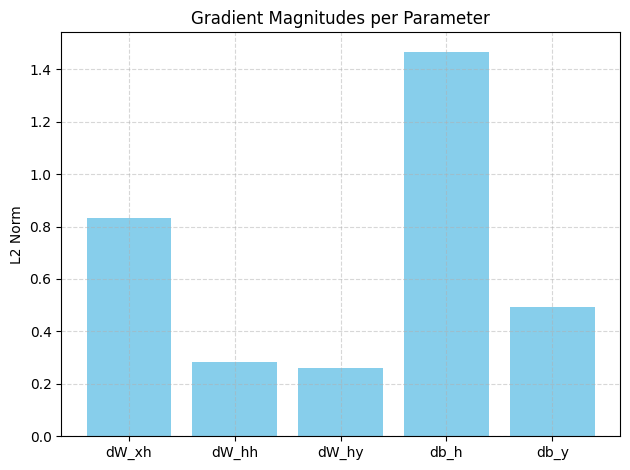

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- STEP 1: Input ----------
word_vectors = {
    "I": np.array([0.1, 0.2]),
    "love": np.array([0.5, 0.1]),
    "NLP": np.array([0.3, 0.7])
}
sentence = ["I", "love", "NLP"]
true_label = np.array([0, 1])  # class 1 = positive

# ---------- STEP 2: RNN Parameters ----------
np.random.seed(42)
W_xh = np.array([[0.1, 0.2],
                 [0.3, 0.4]])
W_hh = np.array([[0.5, -0.1],
                 [0.2,  0.6]])
W_hy = np.array([[ 1.0, -1.0],
                 [-1.0,  1.0]])
b_h = np.zeros(2)
b_y = np.zeros(2)

# ---------- STEP 3: Forward Pass ----------
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

h_0 = np.zeros(2)
h_list = [h_0]
x_list = []

# Forward through time
for word in sentence:
    x_t = word_vectors[word]
    x_list.append(x_t)
    h_prev = h_list[-1]
    h_t = np.tanh(np.dot(W_xh, x_t) + np.dot(W_hh, h_prev) + b_h)
    h_list.append(h_t)

# Final prediction
logits = np.dot(W_hy, h_list[-1]) + b_y
y_pred = softmax(logits)
initial_loss = -np.log(y_pred[np.argmax(true_label)])

# ---------- STEP 4: Backpropagation Through Time ----------
# Output layer gradient
d_logits = y_pred - true_label

# Gradients for output weights
dW_hy = np.outer(d_logits, h_list[-1])
db_y = d_logits.copy()
dh_next = np.dot(W_hy.T, d_logits)

# Initialize RNN gradients
dW_xh = np.zeros_like(W_xh)
dW_hh = np.zeros_like(W_hh)
db_h = np.zeros_like(b_h)

# BPTT through time
for t in reversed(range(len(sentence))):
    h_t = h_list[t+1]
    h_prev = h_list[t]
    x_t = x_list[t]

    dz = (1 - h_t**2) * dh_next  # tanh' * dh
    db_h += dz
    dW_xh += np.outer(dz, x_t)
    dW_hh += np.outer(dz, h_prev)

    dh_next = np.dot(W_hh.T, dz)

# ---------- STEP 5: Update Weights ----------
learning_rate = 0.1
W_xh -= learning_rate * dW_xh
W_hh -= learning_rate * dW_hh
W_hy -= learning_rate * dW_hy
b_h  -= learning_rate * db_h
b_y  -= learning_rate * db_y

# ---------- STEP 6: Forward Again After Update ----------
h_0 = np.zeros(2)
h_list = [h_0]
x_list = []

for word in sentence:
    x_t = word_vectors[word]
    x_list.append(x_t)
    h_prev = h_list[-1]
    h_t = np.tanh(np.dot(W_xh, x_t) + np.dot(W_hh, h_prev) + b_h)
    h_list.append(h_t)

logits = np.dot(W_hy, h_list[-1]) + b_y
y_pred = softmax(logits)
updated_loss = -np.log(y_pred[np.argmax(true_label)])

# ---------- STEP 7: Print Comparison ----------
print("📉 Loss Before Update:", round(initial_loss, 4))
print("📉 Loss After  Update:", round(updated_loss, 4))

# ---------- STEP 8: Visualize Gradient Flow ----------
gradients = {
    "dW_xh": np.linalg.norm(dW_xh),
    "dW_hh": np.linalg.norm(dW_hh),
    "dW_hy": np.linalg.norm(dW_hy),
    "db_h": np.linalg.norm(db_h),
    "db_y": np.linalg.norm(db_y),
}

plt.bar(gradients.keys(), gradients.values(), color="skyblue")
plt.title("Gradient Magnitudes per Parameter")
plt.ylabel("L2 Norm")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Sentiment Analysis

In [ ]:
sentences = ['i love it', 'i hate it', 'so good', 'very bad', 'awesome movie', 'worst ever']
labels = [1, 0, 1, 0, 1, 0]

In [ ]:
# 1. Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
X = tokenizer.texts_to_sequences(sentences)
X = pad_sequences(X, padding='post')
y = np.array(labels)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# 2. Build RNN model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=8, input_length=X.shape[1]),
    SimpleRNN(16),
    Dense(1, activation='sigmoid')
])


In [ ]:
# 3. Compile and Train
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=50, verbose=0)

In [ ]:
# 4. Predict
test_sent = ['really good']
test_seq = tokenizer.texts_to_sequences(test_sent)
test_seq = pad_sequences(test_seq, maxlen=X.shape[1], padding='post')
print("Prediction (1=pos, 0=neg):", model.predict(test_seq))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Prediction (1=pos, 0=neg): [[0.6426244]]


## Machine Translation

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Dummy parallel corpus
eng_sentences = ['hi there', 'hello you', 'thanks much']
fr_sentences  = ['salut toi', 'bonjour toi', 'merci beaucoup']

# Step 2: Tokenize and pad inputs
tok_en = Tokenizer()
tok_en.fit_on_texts(eng_sentences)
X = tok_en.texts_to_sequences(eng_sentences)
X = pad_sequences(X, padding='post')
vocab_en = len(tok_en.word_index) + 1
timesteps = X.shape[1]

tok_fr = Tokenizer()
tok_fr.fit_on_texts(fr_sentences)
y_seq = tok_fr.texts_to_sequences(fr_sentences)
y_seq = pad_sequences(y_seq, padding='post')
vocab_fr = len(tok_fr.word_index) + 1

# Step 3: Convert y_seq to one-hot (shape: batch, timesteps, vocab_size)
y = tf.keras.utils.to_categorical(y_seq, num_classes=vocab_fr)

# Final shape checks
print("X shape:", X.shape)           # e.g., (3, 2)
print("y_seq shape:", y_seq.shape)   # (3, 2)
print("y shape (one-hot):", y.shape) # (3, 2, vocab_fr)

X shape: (3, 2)
y_seq shape: (3, 2)
y shape (one-hot): (3, 2, 6)


In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_en, output_dim=8, input_length=timesteps),
    SimpleRNN(16, return_sequences=True),
    Dense(vocab_fr, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y, epochs=300, verbose=0)

# Step 4: Translate test sentence
test = ['hello you']
test_seq = tok_en.texts_to_sequences(test)
test_seq = pad_sequences(test_seq, maxlen=timesteps, padding='post')
pred = model.predict(test_seq)

# Step 5: Decode
idx2word = {i: w for w, i in tok_fr.word_index.items()}
translation = [idx2word.get(np.argmax(vec), '') for vec in pred[0]]
print("Translation:", ' '.join(translation))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Translation: bonjour toi
